# Introduzione ed obiettivo

L’obiettivo della presente analisi è quello di studiare l’andamento del prezzo di chiusura di Bitcoin nel tempo e di costruire dei modelli capaci di prevederne l’evoluzione futura (seppur con le dovute limitazioni, vista la natura fortemente volatile di Bitcoin).

# 1. Descrizione e preparazione del dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install pandas matplotlib statsmodels

In [2]:
# Importiamo le librerie necessarie
import pandas as pd
import matplotlib.pyplot as plt

# Carichiamo il dataset
#/content/drive/MyDrive/bit-dataset/BTC-Daily.csv
file_path = "/content/drive/MyDrive/bit-dataset/BTC-Daily.csv"
btc_data = pd.read_csv(file_path)

# Mostra le info del dataset per capire la struttura
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


Il dataset in esame è composto dalle seguenti colonne:
- **date**: Colonna delle date, attualmente in formato stringa.
- **open**: Prezzo di apertura.
- **high**: Prezzo massimo.
- **low**: Prezzo minimo.
- **close**: Prezzo di chiusura.
- **Volume** BTC: Volume scambiato in Bitcoin.
- **Volume USD**: Volume scambiato in dollari.

È necessario convertire la colonna `date` in formato `datetime` per poterla utilizzare come indice della serie temporale.

In [3]:
# Selezione delle colonne di interesse
selected_columns = ['date', 'close', 'Volume BTC', 'Volume USD']
btc_data = btc_data[selected_columns].copy()

# Converte la colonna 'date' in datetime e la setta come indice
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_data.set_index('date', inplace=True)

# Ordinare per data (giusto per sicurezza)
btc_data.sort_index(inplace=True)

# Mostra statistiche descrittive del dataset
btc_data.describe()

,close,Volume BTC,Volume USD
count,2651.000000,2.651000e+03,2.651000e+03
mean,11709.326213,1.330041e+07,6.099369e+07
std,16282.908704,4.715366e+07,1.072838e+08
min,162.000000,0.000000e+00,0.000000e+00
25%,654.370000,5.357883e+03,9.516170e+03
50%,6407.770000,1.503310e+04,2.288982e+07
75%,10726.425000,3.435336e+06,8.018383e+07
max,67559.000000,7.723295e+08,1.446125e+09


**Statistiche principali**:
- Numero di **osservazioni**: 2651
- **Media** del prezzo di chiusura: 11.709 USD
- **Massimo** valore storico del prezzo di chiusura: 67.559 USD
- **Minimo** storico: 162 USD

**Osservazioni iniziali**:
* I prezzi mostrano una crescita nel tempo con elevata volatilità.
* I volumi scambiati variano significativamente, indicando fluttuazioni nel mercato.

# 2. Analisi Esplorativa: Trend e Stagionalità

## 2.1 Analisi visiva del dataset
Una prima analisi esplorativa può essere condotta graficando il prezzo di chiusura **giornaliero** del Bitcoin sul periodo disponibile.

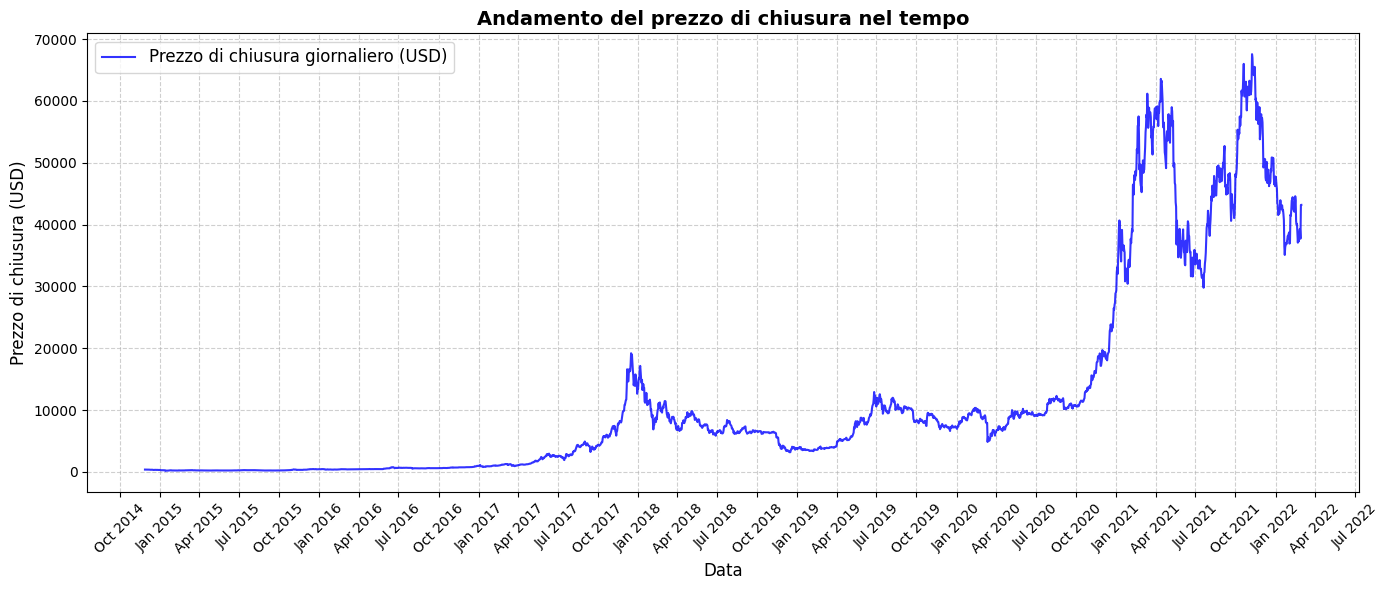

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot del prezzzo di chiusura nel tempo
plt.figure(figsize=(14, 6))
plt.plot(btc_data['close'], label='Prezzo di chiusura giornaliero (USD)', alpha=0.8, linewidth=1.5, color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formattazione mese/anno
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervallo di 3 mesi
plt.xticks(rotation=45)
plt.title('Andamento del prezzo di chiusura nel tempo', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Prezzo di chiusura (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Da esso emergono**:
- Un periodo iniziale (2014–2016) in cui i valori erano mediamente molto più bassi.
- Una prima “bolla” significativa a fine 2017–inizio 2018, in cui Bitcoin ha superato i 19.000 USD.
- Un ridimensionamento nel biennio 2018–2019, con valori spesso tra i 6.000 e i 10.000 USD.
- Un nuovo forte incremento a partire dalla metà del 2020, che ha portato il prezzo a superare i 60.000 USD nel 2021.

## 2.2 Decomposizione della serie

**Resample** della serie aggregando i dati su base settimanale

In [5]:
# Resample settimanale: media per 'close', somma per 'Volume BTC' e 'Volume USD'
btc_data = btc_data.resample('W').agg({
    'close': 'mean',         # Media del prezzo di chiusura
    'Volume BTC': 'sum',     # Somma dei volumi in BTC
    'Volume USD': 'sum'      # Somma dei volumi in USD
})

btc_data.head()

,close,Volume BTC,Volume USD
date,,,
2014-11-30,375.446667,7112601.84,18908.67
2014-12-07,375.200000,16517720.03,43947.46
2014-12-14,352.615714,23580587.27,66456.88
2014-12-21,326.371429,27008687.42,84408.39
2014-12-28,324.420000,15610832.10,47996.74


Divisione del dataset in **80%** training set e **20%** test set

In [6]:
# Calcolo dell'indice di divisione 80-20
split_index = int(len(btc_data) * 0.8)

# Divisione del dataset
train_data = btc_data.iloc[:split_index]['close']
test_data = btc_data.iloc[split_index:]['close']

# Periodi di training e test
training_period = f"Training data: {train_data.index.min().strftime('%Y-%m-%d')} to {train_data.index.max().strftime('%Y-%m-%d')}"
testing_period = f"Test data: {test_data.index.min().strftime('%Y-%m-%d')} to {test_data.index.max().strftime('%Y-%m-%d')}"

training_period, testing_period

('Training data: 2014-11-30 to 2020-09-20',
 'Test data: 2020-09-27 to 2022-03-06')

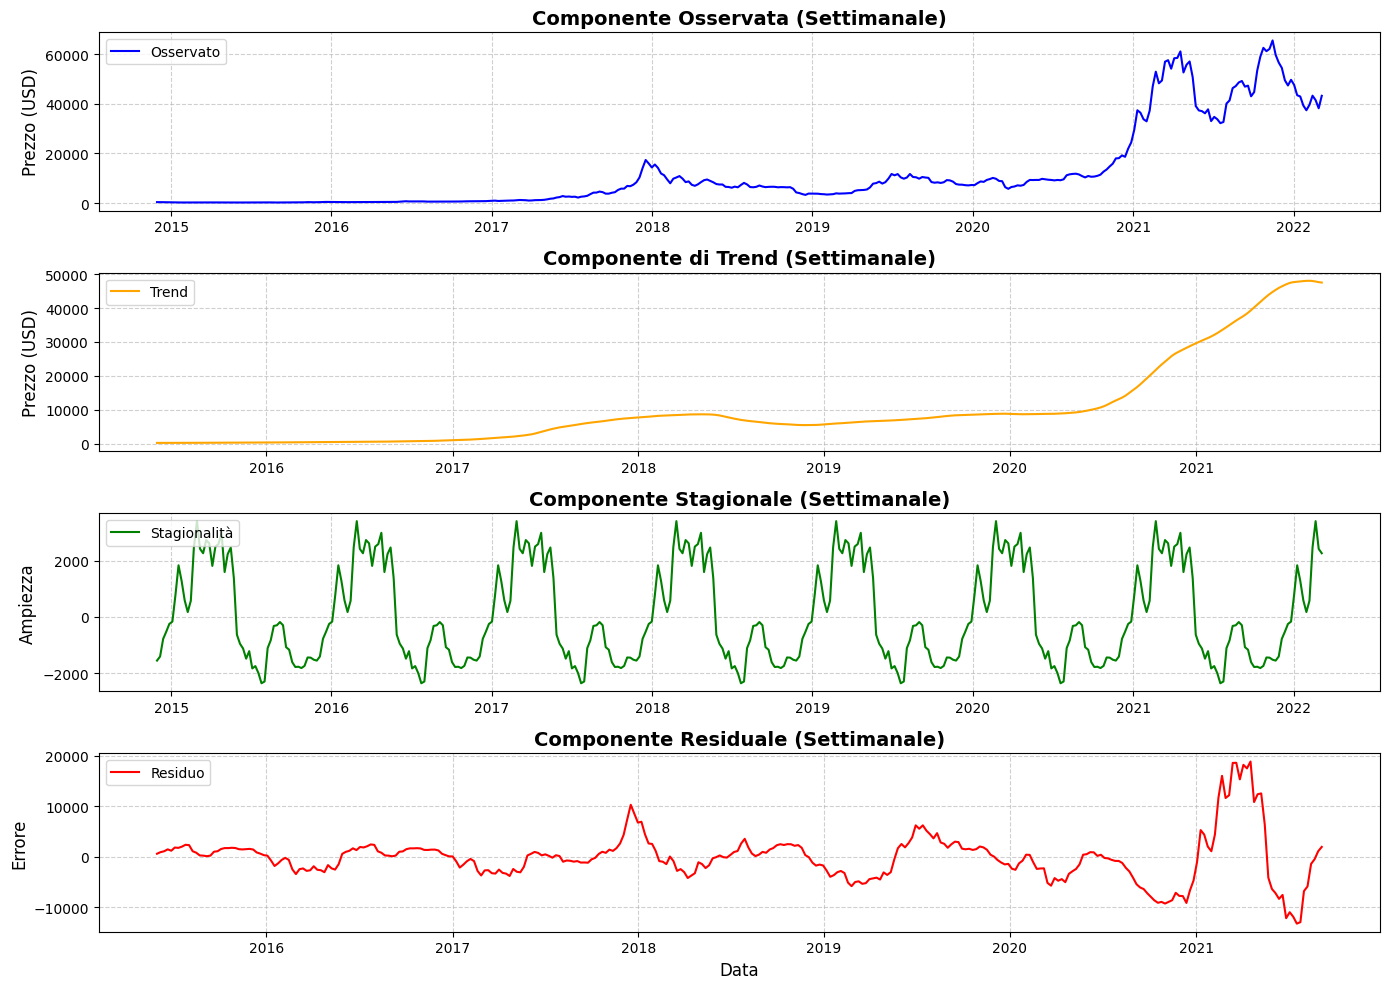

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposizione della serie temporale settimanale
decomposition = seasonal_decompose(btc_data['close'], model='additive', period=52)  # 52 settimane per la stagionalità annuale
plt.figure(figsize=(14, 10))

# Osservato
plt.subplot(411)
plt.plot(decomposition.observed, label='Osservato', color='blue', linewidth=1.5)
plt.title('Componente Osservata (Settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('Prezzo (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange', linewidth=1.5)
plt.title('Componente di Trend (Settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('Prezzo (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Stagionalità
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Stagionalità', color='green', linewidth=1.5)
plt.title('Componente Stagionale (Settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('Ampiezza', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Residuo
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuo', color='red', linewidth=1.5)
plt.title('Componente Residuale (Settimanale)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Errore', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

- Componente **osservata**: mostra la serie temporale originale riferita al prezzo di chiusura del Bitcoin.
- Componente di **Trend**: una linea “smussata” che evidenzia il trend complessico nel lungo periodo. In questo caso, è ben visibile l’ascesa su più anni.
- Componente **Stagionale**: evidenzia pattern ripetitivi annuali che potrebbero riflettere comportamenti stagionali del mercato della criptovaluta.
- Componente **Residuale**: ciò che resta dopo avere rimosso trend e stagionalità, includendo oscillazioni impreviste e picchi di volatilità. Contiene le variazioni che non possono essere spiegate dal trend e dalla stagionalità. Appaiono abbastanza irregolari, indicando la presenza di volatilità non catturata.

# 3. Verifica della Stazionarietà e Differenziazione
Verificare la stazionarietà della serie per poter costruire modelli **ARIMA** o **SARIMA(X)**, effettuando test ADF.

## 3.1 Test di Stazionarietà

In [8]:
from statsmodels.tsa.stattools import adfuller

# Esegue l'Augmented Dickey-Fuller test sul prezzo di chiusura
adf_test = adfuller(btc_data['close'].dropna())

# Raccoglie e mostra i risultati del test ADF
adf_results = pd.Series(
    {
        "ADF Test Statistic": adf_test[0],
        "p-value": adf_test[1],
        "Lags Used": adf_test[2],
        "Number of Observations": adf_test[3],
        "Critical Value (1%)": adf_test[4]["1%"],
        "Critical Value (5%)": adf_test[4]["5%"],
        "Critical Value (10%)": adf_test[4]["10%"],
    }
)

adf_results

ADF Test Statistic         -0.082164
p-value                     0.951186
Lags Used                  17.000000
Number of Observations    362.000000
Critical Value (1%)        -3.448544
Critical Value (5%)        -2.869557
Critical Value (10%)       -2.571041
dtype: float64

Dai risultati del test di **Dickey-Fuller Aumentato** (ADF Test) otteniamo i seguenti risultati:
- **Statistiche di Test**: -0.082164
- **p-value**: 0.951186
- **Critical Values**:
  - 1%: -3.448544
  - 5%: -2.869557
  - 10%: -2.571041

La serie originale non è stazionaria. Questo è evidenziato dal p-value superiore a 0.05, che **non** consente di rifiutare l’ipotesi nulla (la serie ha una radice unitaria, quindi non è stazionaria).
Anche La statistica ADF (-0.082164) è superiore a tutti i valori critici (-3.448544, -2.869557, -2.571041), supportando ulteriormente l’ipotesi che la serie non sia stazionaria.

## 3.2 Differenziazione
Differenziazione del primo ordine della serie temporale e ripetiamo l'ADF test.

In [9]:
# Esegue la differenziazione di primo ordine sul prezzo di chiusura
btc_data['close_diff'] = btc_data['close'].diff()

# Ripete il test ADF sui dati differenziati
adf_test_diff = adfuller(btc_data['close_diff'].dropna())

# Colleziona e mostra i risultati del test ADF dopo la differenziazione
adf_diff_results = pd.Series(
    {
        "ADF Test Statistic": adf_test_diff[0],
        "p-value": adf_test_diff[1],
        "Lags Used": adf_test_diff[2],
        "Number of Observations": adf_test_diff[3],
        "Critical Value (1%)": adf_test_diff[4]["1%"],
        "Critical Value (5%)": adf_test_diff[4]["5%"],
        "Critical Value (10%)": adf_test_diff[4]["10%"],
    }
)

adf_diff_results

ADF Test Statistic         -5.106920
p-value                     0.000014
Lags Used                  16.000000
Number of Observations    362.000000
Critical Value (1%)        -3.448544
Critical Value (5%)        -2.869557
Critical Value (10%)       -2.571041
dtype: float64

Dopo la prima **differenziazione**, i risultati del test ADF indicano che la serie è ora stazionaria:
- **Statistiche di Test**: -5.106920
- **p-value**: 0.000014
- **Critical Values**:
  - 1%: -3.448544
  - 5%: -2.869557
  - 10%: -2.571041

La statistica del test (-5.106920) è inferiore ai valori critici a tutti i livelli di significatività (1%, 5%, 10%), ed il p-value estremamente basso **consente** di rifiutare l’ipotesi nulla di non stazionarietà. Questo indica che la serie differenziata è ora stazionaria.

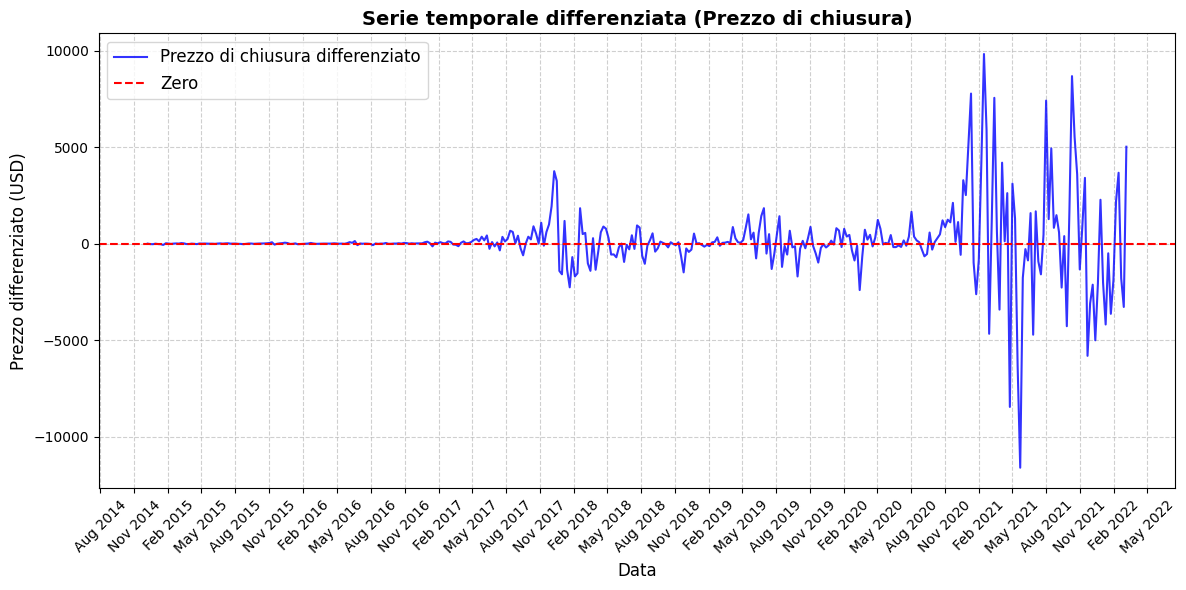

In [10]:
# Plot delle serie differenziate
plt.figure(figsize=(12, 6))
plt.plot(btc_data['close_diff'], label='Prezzo di chiusura differenziato', alpha=0.8, linewidth=1.5, color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervallo di 3 mesi
plt.xticks(rotation=45)

plt.title('Serie temporale differenziata (Prezzo di chiusura)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Prezzo differenziato (USD)', fontsize=12)
plt.axhline(0, linestyle="--", color="red", linewidth=1.5, label='Zero')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

I valori della nuova serie oscillano attorno allo zero in maniera più o meno casuale, indicando un buon livello di stazionarietà. Possiamo procedere con la costruzione di modelli ARIMA e SARIMA(X).

## 3.3 ACF e PACF

Stima dei parametri **p** e **q** dei modelli ARIMA e SARIMA tramite i correlogrammi ACF e PACF.

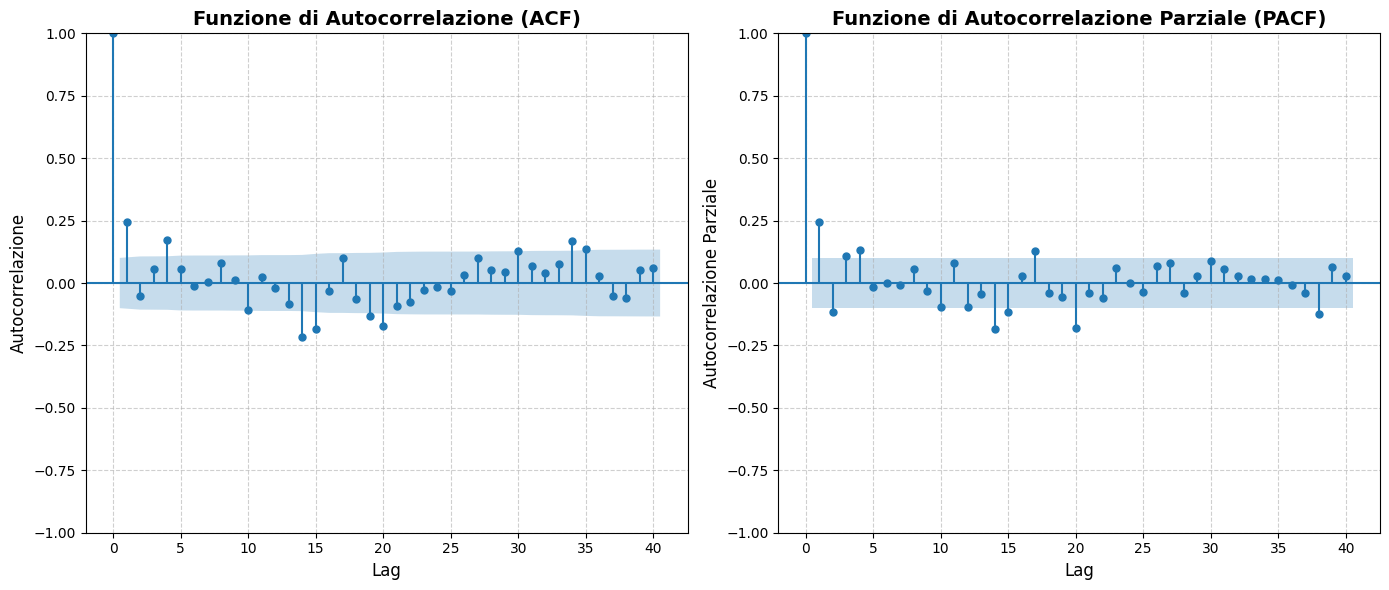

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Creazione dei grafici ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# ACF
plot_acf(btc_data['close_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Funzione di Autocorrelazione (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelazione', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# PACF
plot_pacf(btc_data['close_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Funzione di Autocorrelazione Parziale (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Autocorrelazione Parziale', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Mostra i grafici
plt.tight_layout()
plt.show()

Interpretazione dei grafici ACF e PACF
1. **ACF (Funzione di Autocorrelazione)**:
  - Il grafico ACF mostra la correlazione tra la serie differenziata e i suoi valori passati (lag).
  - Decadimento rapido dell’autocorrelazione, con significatività visibile solo nei primi lag. Questo comportamento è tipico di una serie che contiene un componente di media mobile (MA).
  - Il primo lag significativo suggerisce un modello con un termine di media mobile di ordine 1 (q = 1).
2. **PACF (Funzione di Autocorrelazione Parziale)**:
  - Il grafico PACF evidenzia una correlazione diretta significativa al primo lag, mentre gli altri lags mostrano correlazioni trascurabili.
  - Suggerisce che la componente autoregressiva (AR) ha una struttura di basso ordine, probabilmente con p = 1.
3. **Combinazione di ACF e PACF**:
  - L’ACF e il PACF insieme suggeriscono che la serie differenziata può essere ben modellata con un modello (1, 1, 1).
  - Ordini stimati:
    - **p = 1**: componente autoregressiva.
    - **d = 1**: differenziazione di primo ordine per rendere la serie stazionaria.
    - **q = 1**: componente di media mobile.

# 4. Costruzione del modello ARIMA

Utilizzando il metodo `auto_arima` possimao determinare parametri (p, q) ottimali per il modello ARIMA, ovvero quelli che minimizzano l'AIC.

In [12]:
! pip install pmdarima


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [13]:
from pmdarima import auto_arima

# Utilizzo di auto_arima per trovare i parametri migliori
auto_arima_model = auto_arima(
    btc_data['close'],
    seasonal=False,  # Nessuna stagionalità per ora
    trace=True,      # Mostrare il processo
    error_action='ignore',  # Ignora errori
    suppress_warnings=True, # Sopprimi i warning
    stepwise=True,          # Approccio iterativo per trovare i migliori parametri
    max_order=10            # Limite sulla somma di p+d+q
)

# Mostrare i parametri migliori trovati
print(auto_arima_model.summary())

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homeb

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6729.351, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6757.304, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6735.407, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6729.533, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6756.810, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6732.754, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6735.096, Time=0.04 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6719.485, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6727.503, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6727.134, Time=0.08 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6726.303, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6723.096, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6725.107, Time=0.05 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6729.149, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6718.304, Time=0.19 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6733.035, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6725.416, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=6725.912, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=6725.110, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6733.852, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6722.064, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=6723.888, Time=0.03 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=6727.933, Time=0.06 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 1.476 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  380
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -3353.152
Date:                Mon, 03 Feb 2025   AIC                           6718.304
Time:                        09:23:24   BIC                           6741.930


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Struttura del Modello**
1. **p = 3** --> Indica una componente autoregressiva (AR) con tre termini. Questo suggerisce che i valori passati fino a tre lag influenzano il valore corrente, catturando dipendenze a lungo termine.
2. **d = 1** --> Una differenziazione di primo ordine è necessaria per rendere la serie stazionaria, come confermato dal test ADF.
3. **q = 2** --> Una singola componente di media mobile (MA) è inclusa. Questo cattura dipendenze immediate e a breve termine tra variazioni passate e il valore corrente.

**Metriche del Modello**
- **AIC (Akaike Information Criterion)**: 6718.304 --> Il valore elevato suggerisce che, pur essendo il modello adeguato, potrebbe non essere il migliore possibile. Un AIC più basso indica un modello migliore.
- **Log-Likelihood**: -3353.152 --> Riflette quanto il modello si adatta ai dati osservati. Sebbene non interpretabile isolatamente, è utile per confrontare diversi modelli. Maggiore rispetto ai modelli più semplici, suggerendo un migliore adattamento ai dati.

**Validazione Statistica**
1. **Test di Ljung-Box** (Correlazione dei residui):
  - **Probabilità Q**: 0.67 --> I residui non mostrano correlazione significativa al primo lag, il che indica un buon adattamento del modello. Questo è positivo.
2. **Test di Jarque-Bera** (Normalità dei residui):
  - **p-value**: 0.00 --> I residui non seguono una distribuzione normale, il che è tipico per dati finanziari caratterizzati da fluttuazioni estreme e code pesanti.
3. **Eteroschedasticità** (Varianza non costante):
  - **Indice H**: 4647.73, **p-value**: 0.00 --> La varianza non costante nei residui (eteroschedasticità) è significativa, coerente con l’elevata volatilità dei dati finanziari, come il Bitcoin.


**Punti di Forza**
1. **Adattamento**: Rispetto a modelli più semplici, come ARIMA(0,1,1), ARIMA(3,1,2) cattura meglio la complessità della serie temporale. L’inclusione di più termini AR e MA permette di catturare sia dipendenze a lungo termine che variazioni immediate.
2. **Residui non correlati**: Il test di Ljung-Box conferma che il modello riesce a catturare le dipendenze temporali principali.


**Limitazioni**
1. **Assenza di Stagionalità**: Il modello non considera possibili pattern stagionali o cicli più complessi, che potrebbero essere rilevanti data la natura annuale della stagionalità identificata nella decomposizione.
2. **Elevata Varianza Residua**: L’eteroschedasticità nei residui indica che il modello potrebbe essere migliorato utilizzando tecniche specifiche per dati con varianza non costante, come modelli GARCH o SARIMA con variabili esogene.
3. **Residui non Normali**: La non normalità dei residui riduce l’affidabilità degli intervalli di confidenza, suggerendo che il modello potrebbe non catturare completamente la distribuzione dei dati.

## 4.2 Addestramento ARIMA(3,1,2)

Addestriamo il modello con i parametri identificati e procediamo con la previsione dei valori dei bitcoin sul test set con il metodo `forecast`.

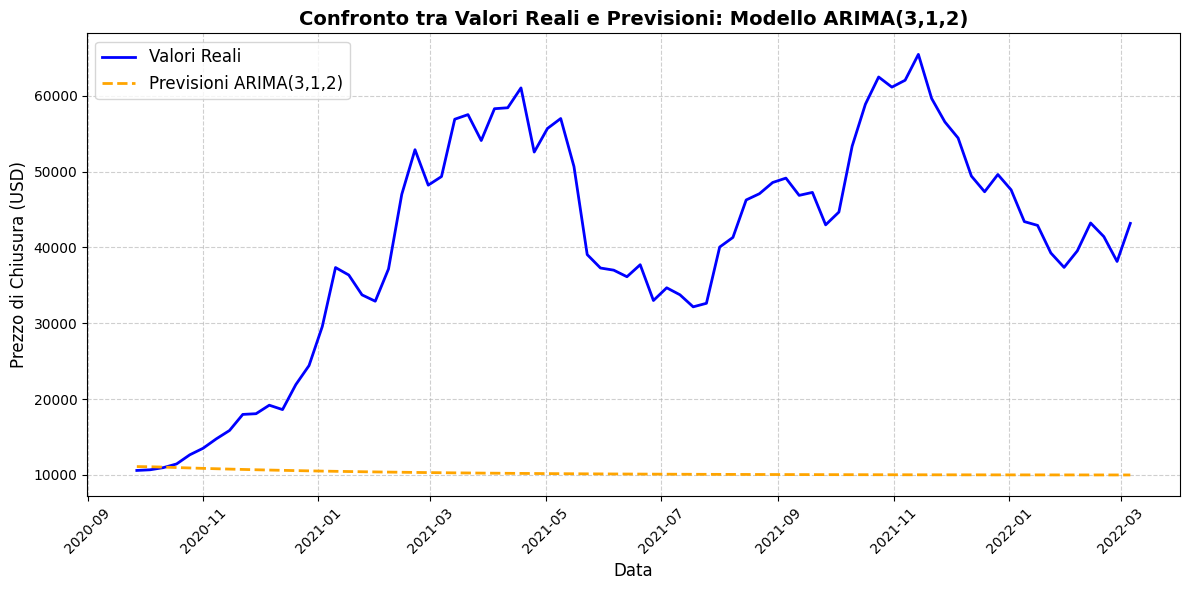

Mean Squared Error (MSE): 1147099488.33
Root Mean Squared Error (RMSE): 33868.86


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Addestrare il modello ARIMA(3, 1, 2)
model_arima = ARIMA(train_data, order=(3, 1, 2))
model_fit_arima = model_arima.fit()

# Previsioni sul test set
forecast_arima = model_fit_arima.forecast(steps=len(test_data))

# Calcolo di MSE e RMSE
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

# Visualizzazione del confronto tra previsioni e valori reali
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Valori Reali', color='blue', linewidth=2)
plt.plot(test_data.index, forecast_arima, label='Previsioni ARIMA(3,1,2)', linestyle='--', color='orange', linewidth=2)
plt.title('Confronto tra Valori Reali e Previsioni: Modello ARIMA(3,1,2)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Prezzo di Chiusura (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizzazione delle metriche di errore
print(f"Mean Squared Error (MSE): {mse_arima:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima:.2f}")

**Risultati del modello ARIMA(3, 1, 2)**

1. **Metriche di valutazione**:
	- **Mean Squared Error** (MSE): 1,147,103,244.64 USD
	- **Root Mean Squared Error** (RMSE): 33,868.91 USD

	Questi valori mostrano un errore elevato nelle previsioni, indicando che il modello non riesce a catturare in modo efficace la volatilità e le dinamiche di prezzo del Bitcoin nel test set. Questo è particolarmente evidente in un mercato altamente volatile come quello delle criptovalute.

2. **Visualizzazione delle previsioni**:

	Il modello genera previsioni 'quasi statiche' o con trend costante, senza adattarsi alle fluttuazioni osservate nei dati reali, non riuscendo quindi a catturare le variazioni dinamiche del prezzo reale.
	L’ARIMA(3,1,2) include tre termini autoregressivi (AR) e due termini di media mobile (MA), ma la sua complessità non si traduce in un miglioramento delle previsioni.

## 4.3 Analisi residui ARIMA

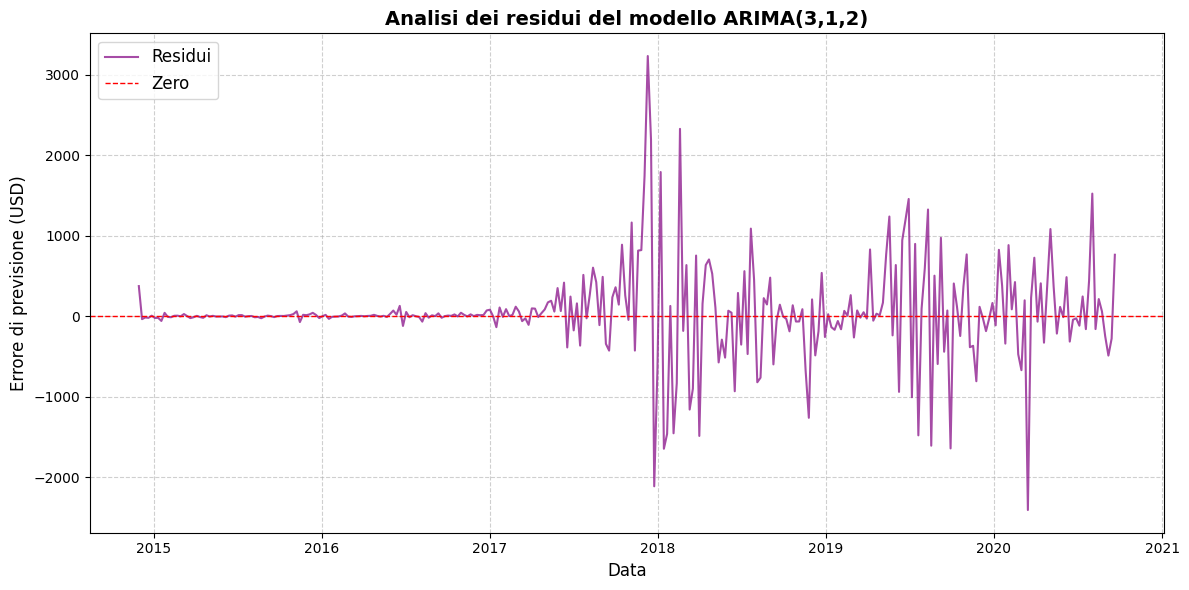

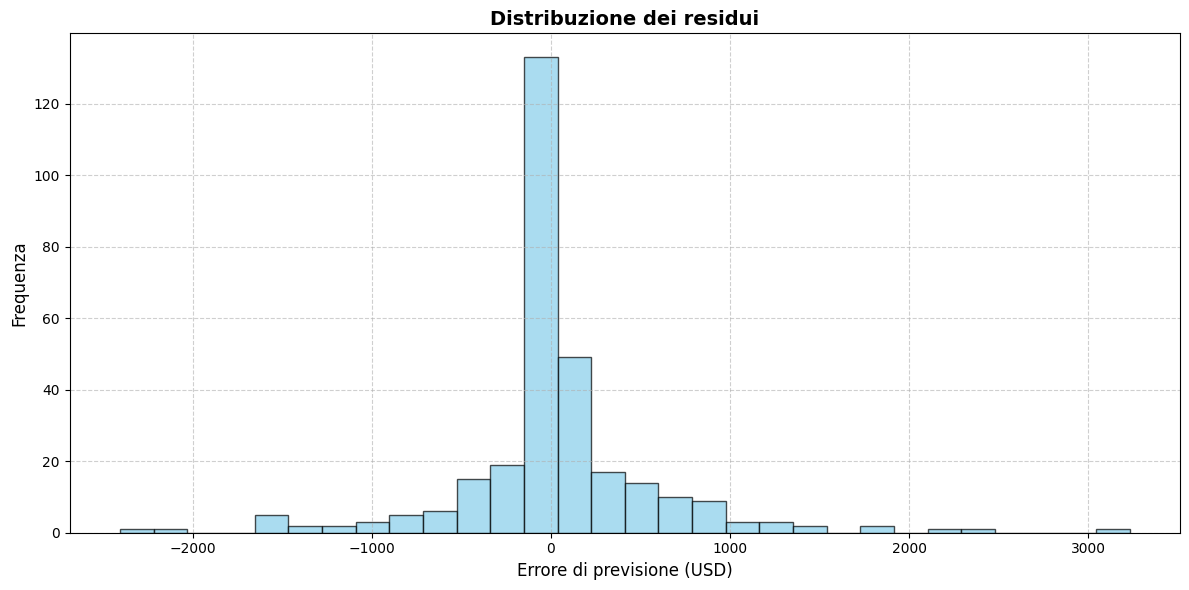

In [15]:
# Analisi dei residui del modello ARIMA(3, 1, 2)
residuals_arima = model_fit_arima.resid

# Grafico dei residui
plt.figure(figsize=(12, 6))
plt.plot(residuals_arima, label='Residui', color='purple', alpha=0.7, linewidth=1.5)
plt.axhline(0, linestyle='--', color='red', linewidth=1, label='Zero')
plt.title('Analisi dei residui del modello ARIMA(3,1,2)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Errore di previsione (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Istogramma dei residui
plt.figure(figsize=(12, 6))
plt.hist(residuals_arima, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribuzione dei residui', fontsize=14, fontweight='bold')
plt.xlabel('Errore di previsione (USD)', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# Test statistici sui residui
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test di Ljung-Box per autocorrelazione dei residui
ljung_box_results = acorr_ljungbox(residuals_arima, lags=[10], return_df=True)
ljung_box_results

,lb_stat,lb_pvalue
10,19.642947,0.032817


1. **Grafico dei residui**:
	- I residui oscillano intorno a zero, ma mostrano un pattern non completamente casuale.
	- Ciò suggerisce che il modello potrebbe non catturare tutte le dinamiche della serie temporale. Eventuali componenti stagionali o relazioni a lungo termine potrebbero essere trascurate.

2. **Distribuzione dei residui**:
	- L’istogramma indica una distribuzione non normale, con possibili deviazioni e code pesanti. Questo riflette la presenza di outlier e variazioni improvvise nel prezzo del Bitcoin.
	- La distribuzione non normale è coerente con la natura volatile dei dati finanziari, come il Bitcoin, caratterizzati da outlier e cambiamenti improvvisi di prezzo.

3. **Test di Ljung-Box**:
	- **Statistiche del test**: 19.642947
	- **P-value**: 0.032817
	- Il test rivela autocorrelazione significativa nei residui fino al lag 10. Questo implica che i residui non sono completamente casuali e che il modello non cattura tutte le dipendenze temporali nei dati. C'è ancora dipendenza temporale nei residui.

Il modello **ARIMA(3, 1, 2)** cattura solo parzialmente l'andamento volatile di Bitcoin. Le previsioni generate risultano troppo “piatte” rispetto ai movimenti reali, con una tendenza a smorzare sia i picchi che i crolli osservati nel prezzo.
Possiamo quindi affermare che il modello ARIMA genera previsioni che tendono a restare vicine a una sorta di “media” degli ultimi valori osservati. Rivelando la necessità di utilizzare modelli più complessi come ad esempio **SARIMA(X)**.

# 5. Modello SARIMAX
La scelta di SARIMAX è dettata dall'introduzione della valriabile esogena relativa al **Volume** di scambio dei bitcoin in USD che potrebbe aiutare a spiegare l'andamento del prezzo, migliorando notevolmente la capacità previsionale del modello.
L'idea alla base di questo modello è quella di vedere se una componente stagionale potesse migliorare quindi la previsione del Bitcoin, almeno noi periodi di ripetitività.

## 5.1 Calcolo correlazione tra Volume USD e Volume BTC

In [17]:
# Calcolo della correlazione tra Volume BTC e Volume USD
correlation = btc_data[['Volume BTC', 'Volume USD']].corr()

# Stampa della matrice di correlazione
correlation

,Volume BTC,Volume USD
Volume BTC,1.000000,-0.195343
Volume USD,-0.195343,1.000000


Una correlazione di -0.195343 suggerisce che i due volumi non sono strettamente legati, e che l’aumento o la diminuzione di uno non implica necessariamente un cambiamento proporzionale nell’altro.

Questa debole relazione potrebbe essere dovuta alla natura indipendente delle due variabili: il volume in BTC rappresenta la quantità effettiva scambiata, mentre il volume in USD è influenzato anche dal prezzo del Bitcoin, che è altamente volatile.

In sintesi, data la debole correlazione, è ragionevole includere entrambe le variabili come esogene nel modello SARIMAX, a meno che i test di significatività durante l’addestramento del modello non mostrino che una delle due non contribuisce in modo significativo.

In [18]:
# Selezionare entrambe le variabili esogene
exog_variables = btc_data[['Volume BTC', 'Volume USD']]

# Sincronizzare le variabili esogene con il dataset (se necessario, per evitare problemi di lunghezza)
exog_variables = exog_variables.loc[btc_data.index]

# Verifica le prime righe del dataset delle variabili esogene
print(exog_variables.head())

             Volume BTC  Volume USD
date                               
2014-11-30   7112601.84    18908.67
2014-12-07  16517720.03    43947.46
2014-12-14  23580587.27    66456.88
2014-12-21  27008687.42    84408.39
2014-12-28  15610832.10    47996.74


In [19]:
! pip install pmdarima


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [20]:
from pmdarima import auto_arima

# Determinazione dei parametri ottimali con auto_arima
auto_arima_model = auto_arima(
    btc_data['close'],
    seasonal=True,
    m=52,                    # Periodicità mensile
    exogenous=exog_variables,
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    max_p=3,                 # Limita l'ordine massimo di AR
    d=1,                     # Limita il numero massimo di differenziazioni
    max_q=3,                 # Limita l'ordine massimo di MA
    max_P=2,                 # Limita l'ordine massimo stagionale di AR
    D=1,                     # Limita il numero massimo di differenziazioni stagionali
    max_Q=2,                 # Limita l'ordine massimo stagionale di MA
    max_order=None,          # Somma massima di p+q+P+Q
    n_jobs=-1
)

# Output dei parametri ottimali
print(auto_arima_model.summary())

Performing stepwise search to minimize aic


/opt/homebrew/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,1)[52]             : AIC=5910.249, Time=9.71 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[52]             : AIC=7526.962, Time=0.80 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=7.67 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=5900.287, Time=7.90 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[52]             : AIC=5932.239, Time=2.12 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[52]             : AIC=5905.320, Time=8.84 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[52]             : AIC=5936.239, Time=19.90 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[52]             : AIC=5891.196, Time=7.53 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[52]             : AIC=5906.699, Time=19.46 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,1)[52]             : AIC=5921.282, Time=23.28 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=6.74 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[52]             : AIC=5893.401, Time=8.64 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,0)[52]             : AIC=5895.274, Time=9.00 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[52]             : AIC=5895.462, Time=10.63 sec


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=5893.271, Time=9.26 sec

Best model:  ARIMA(0,1,1)(1,1,0)[52]          
Total fit time: 151.511 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  380
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood               -2940.598
Date:                             Mon, 03 Feb 2025   AIC                           5891.196
Time:                                     09:25:56   BIC                           5910.145
Sample:                                 11-30-2014   HQIC                          5898.757
                                      - 03-06-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

**Parametri del modello**

Non stagionali (p, d, q):
- p=0: Nessuna componente auteregressiva non stagionale.
- d=1: Differenziazione non stagionale per rendere la serie stazionaria.
- q=1: Una singola componente di media mobile non stagionale, utile per catturare la dipendenza immediata dagli errori precedenti.

Stagionali (P, D, Q, m):
- P=1: Una componente autoregressiva stagionale.
- D=1: Differenziazione stagionale per catturare pattern ripetitivi annuali (periodicità = 52 settimane).
- Q=0: Nessuna componente di media mobile stagionale.
- m=52: Periodicità settimanale.

**Coefficiente delle variabili esogene**

1. Volume BTC:
	- Coefficiente: -9.039e-08
	- P-value: 0.922 (non significativo).
	- Il contributo del volume in BTC non sembra rilevante per spiegare la dinamica del prezzo di chiusura.
2. Volume USD:
	- Coefficiente: -3.122e-07
	- P-value: 0.022 (significativo al 5%).
	- Il volume in USD ha un impatto statisticamente significativo sul prezzo, indicando che questa variabile esogena contribuisce a spiegare le variazioni del prezzo di chiusura.

**Statistiche chiave**
- AIC (Akaike Information Criterion): 5891.196
	- Una misura di bontà del modello; valori più bassi indicano un miglior adattamento con minore complessità.
- Log-Likelihood: -21751.956
	- Indica la probabilità del modello dato il dataset. Riflette l'adeguatezza del modello.

**Test diagnostici**
- Ljung-Box (L1) (Q):
	- Prob(Q): 0.77
	- Suggerisce che i residui non mostrano autocorrelazione significativa al primo lag, indicando un buon adattamento del modello.
- Jarque-Bera Test:
	- Statistica JB: 818.56, P-value: 0.00
	- I residui non seguono una distribuzione normale, ma ciò è coerente con la natura volatile dei dati finanziari.
- Heteroskedasticity (H):
	- H = 36.10
	- I residui mostrano eteroschedasticità significativa, suggerendo che la varianza non è costante nel tempo.

**Interpretazione dei parametri**
- ma.L1:
	- 0.2992: Indica una dipendenza significativa dagli errori immediatamente precedenti.
- ar.S.L12:
	- -0.7351: Indica una forte componente autoregressiva stagionale annuale (52 settimane).

**Conclusioni**
- Bontà del modello:
	- Il modello cattura bene la stagionalità e il comportamento della serie temporale. Il volume in USD è una variabile esogena significativa, suggerendo che è utile includerla nel modello.
	- L’assenza di autocorrelazione nei residui è un segnale positivo.
- Limiti:
	- La presenza di eteroschedasticità potrebbe indicare la necessità di modellare la varianza (es. con un modello GARCH).

## 5.2 Addestramento modello SARIMAX(0,1,1)(1,1,0)[52]

Il modello SARIMAX utilizza in questo il metodo `get_forecast` per generare previsioni puntuali e calcolare intervalli di confidenza, fornendo una misura dell’incertezza delle stime. Gli intervalli, basati sulla varianza stimata del modello, indicano il range entro cui i valori reali potrebbero cadere con una certa probabilità (es. 95%), offrendo una visione più completa e informativa delle previsioni.

In [21]:
# Selezionare entrambe le variabili esogene
exog_variables = btc_data[['Volume USD']]

# Sincronizzare le variabili esogene con il dataset (se necessario, per evitare problemi di lunghezza)
exog_variables = exog_variables.loc[btc_data.index]

# Verifica le prime righe del dataset delle variabili esogene
print(exog_variables.head())

# Divisione delle variabili esogene
train_exog = btc_data.iloc[:split_index][['Volume USD']]
test_exog = btc_data.iloc[split_index:][['Volume USD']]

            Volume USD
date                  
2014-11-30    18908.67
2014-12-07    43947.46
2014-12-14    66456.88
2014-12-21    84408.39
2014-12-28    47996.74


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


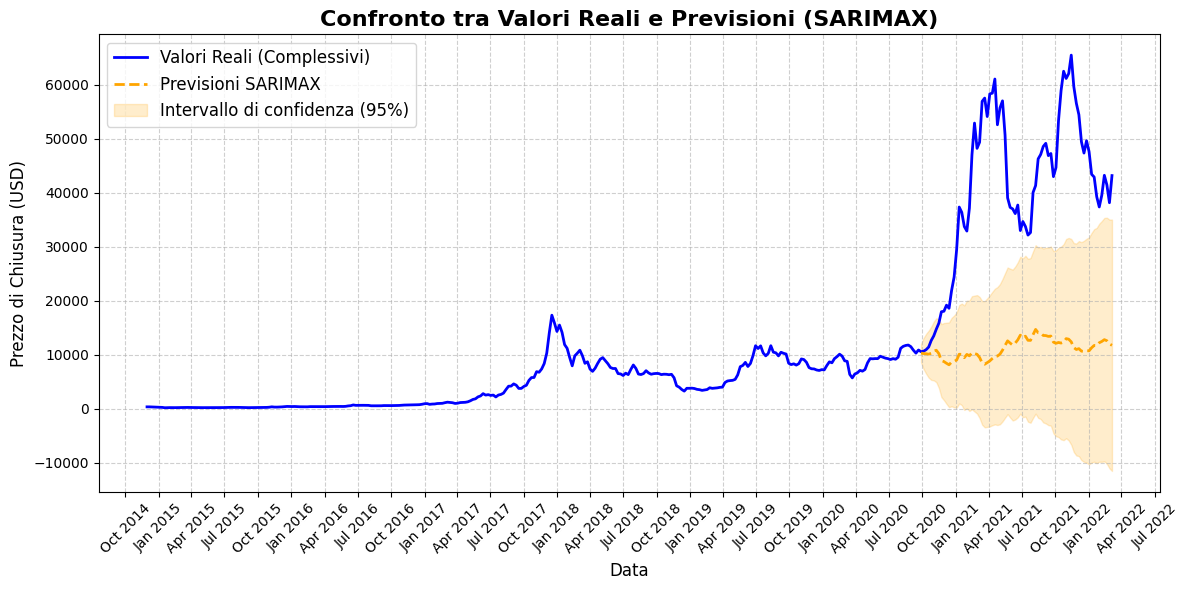

Mean Squared Error (MSE): 1074216626.75
Root Mean Squared Error (RMSE): 32775.24


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Concatenare dati di training e test per avere l'intera serie storica
full_data = pd.concat([train_data, test_data])

# Addestramento del modello SARIMAX con i parametri trovati da auto_arima
sarimax_model = SARIMAX(
    train_data,
    exog=train_exog,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit(disp=False)

# Previsioni sul test set con intervallo di confidenza
forecast_object = sarimax_fit.get_forecast(steps=len(test_data), exog=test_exog)
sarimax_forecast = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

# Valutazione del modello SARIMAX
sarimax_mse = mean_squared_error(test_data, sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)

## Grafico delle previsioni SARIMAX con l'intera serie dei valori reali
plt.figure(figsize=(12, 6))

# Grafico dell'intera serie reale
plt.plot(full_data.index, full_data, label='Valori Reali (Complessivi)', color='blue', linewidth=2)

# Previsioni SARIMAX
plt.plot(test_data.index, sarimax_forecast, label='Previsioni SARIMAX', linestyle='--', color='orange', linewidth=2)

# Intervallo di confidenza
plt.fill_between(
    test_data.index,
    confidence_intervals.iloc[:, 0],  # Limite inferiore
    confidence_intervals.iloc[:, 1],  # Limite superiore
    color='orange', alpha=0.2, label='Intervallo di confidenza (95%)'
)

# Dettagli del grafico
plt.title('Confronto tra Valori Reali e Previsioni (SARIMAX)', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Prezzo di Chiusura (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Visualizzazione delle metriche di errore
print(f"Mean Squared Error (MSE): {sarimax_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {sarimax_rmse:.2f}")

Risultati del modello SARIMAX

**Metriche di valutazione**:
- MSE (Mean Squared Error): 1,074,216,626.75
- RMSE (Root Mean Squared Error):  32,775.24

Queste metriche mostrano un errore elevato, coerente con il comportamento volatile e non lineare del prezzo del Bitcoin. Il modello riesce a catturare alcune tendenze generali ma fatica a prevedere con precisione le fluttuazioni estreme.

**Grafico**:
- La previsione del modello SARIMAX sono piuttosto piatte e non seguono le oscillazioni significative dei valori reali.
- L’intervallo di confidenza (area arancione) è relativamente ampio, indicando un’elevata incertezza nelle previsioni, soprattutto in un mercato volatile come quello del Bitcoin.
- I valori reali mostrano chiaramente che il modello non riesce a catturare i picchi o i crolli significativi osservati nel mercato.

**Componenti principali dell’intervallo di confidenza**
1. Valore previsto (forecast):
	- È il valore centrale, ovvero la stima puntuale fornita dal modello.
	- Indica la “miglior previsione” basata sui dati storici e sul modello.
2. Limiti inferiore e superiore:
	- Limite inferiore: Il limite più basso in cui il valore reale potrebbe trovarsi.
	- Limite superiore: Il limite più alto in cui il valore reale potrebbe trovarsi.
3. Livello di confidenza:
	- Generalmente impostato al 95%, significa che ci aspettiamo che il valore reale cada all’interno dell’intervallo nel 95% dei casi.

L’intervallo di confidenza nelle previsioni rappresenta il range in cui ci aspettiamo che i valori reali cadano con una determinata probabilità (ad esempio, 95%). Questo range è calcolato utilizzando la varianza stimata del modello e gli errori.


## 5.3 Analisi residui SARIMAX

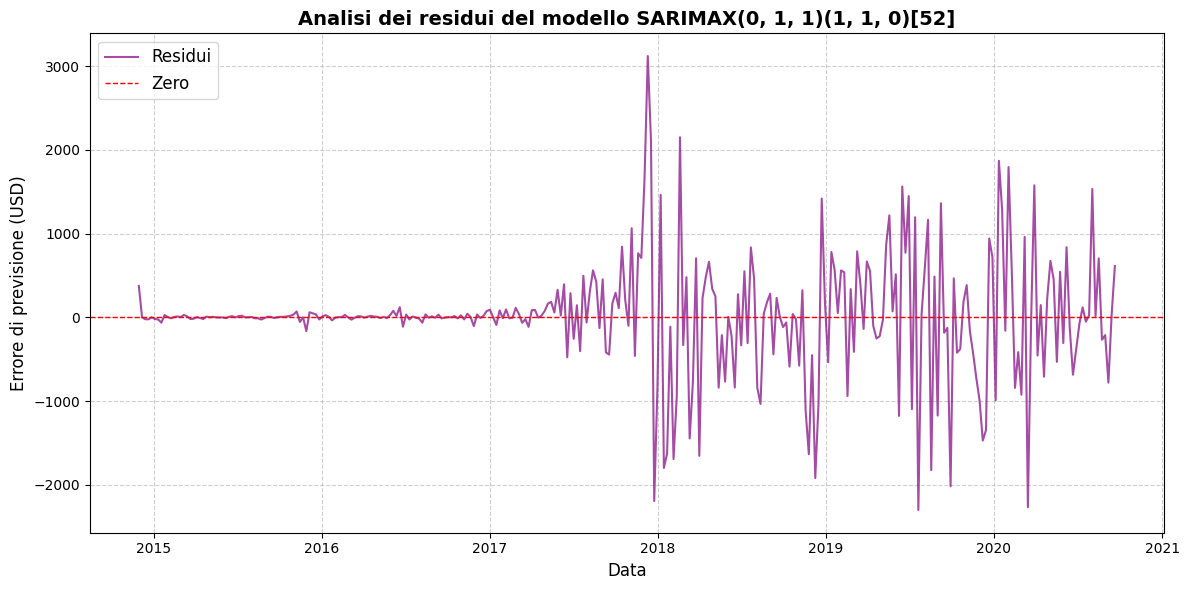

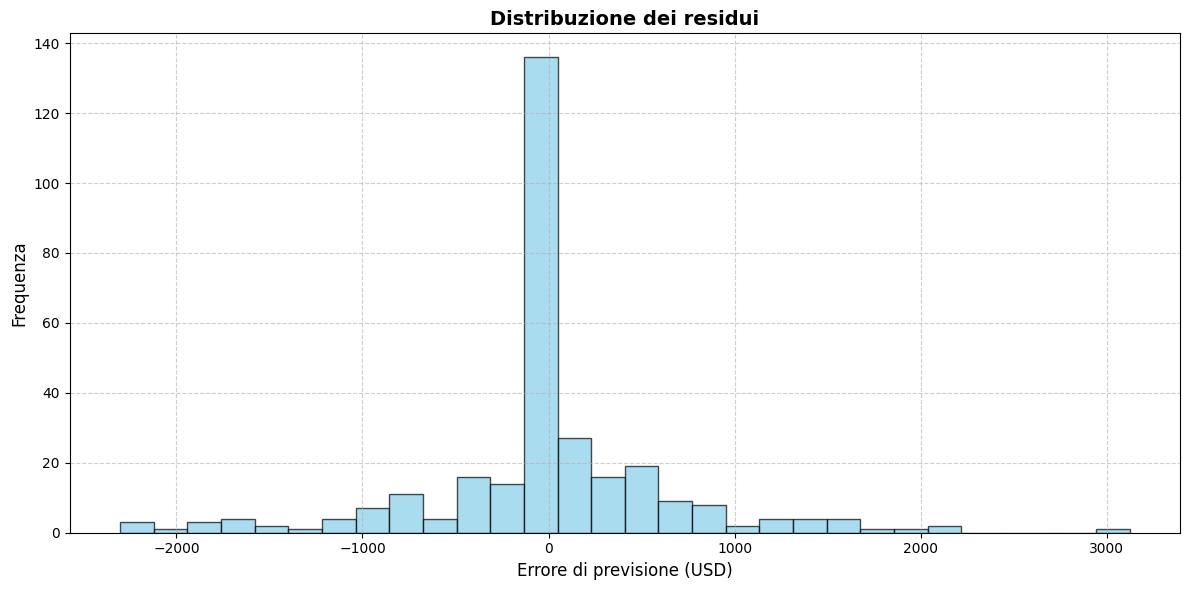

In [23]:
# Analisi dei residui del modello SARIMAX
residuals_sarimax = sarimax_fit.resid

# Grafico dei residui
plt.figure(figsize=(12, 6))
plt.plot(residuals_sarimax, label='Residui', color='purple', alpha=0.7, linewidth=1.5)
plt.axhline(0, linestyle='--', color='red', linewidth=1, label='Zero')
plt.title('Analisi dei residui del modello SARIMAX(0, 1, 1)(1, 1, 0)[52]', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Errore di previsione (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Istogramma dei residui
plt.figure(figsize=(12, 6))
plt.hist(residuals_sarimax, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribuzione dei residui', fontsize=14, fontweight='bold')
plt.xlabel('Errore di previsione (USD)', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test di Ljung-Box per i residui del modello SARIMA/SARIMAX
ljung_box_results_sarimax = acorr_ljungbox(residuals_sarimax, lags=[10], return_df=True)
ljung_box_results_sarimax

,lb_stat,lb_pvalue
10,24.098779,0.007342


1. **Grafico della serie temporale dei residui**
  - I residui oscillano intorno a zero, un buon segno che indica che il modello non presenta bias sistematico. Tuttavia, ci sono variazioni significative in alcuni punti, particolarmente visibili durante i periodi di maggiore volatilità.
  - Nella parte finale del periodo (2021), i residui mostrano un aumento significativo, suggerendo che il modello non cattura correttamente i valori reali in questa fase. Questo potrebbe suggerire che il modello potrebbe non essere in grado di adattarsi a cambiamenti improvvisi o non lineari nei dati (es. volatilità o picchi estremi).

2. **Istogramma dei residui**
  - L’istogramma mostra una distribuzione con code più pesanti rispetto a una normale, caratteristica tipica nei dati finanziari, specialmente per il Bitcoin.
  - Alcuni residui sono significativamente distanti dallo zero, indicando la difficoltà del modello nel catturare eventi estremi (picchi o crolli improvvisi).Questi outlier potrebbero indicare eventi eccezionali non spiegati dal modello, oppure che il modello potrebbe essere migliorato (es. aggiungendo componenti non lineari).


3. **Test di Ljung-Box**
  - Statistica: 24.099
  - p-value: 0.007342
  - L’autocorrelazione significativa nei residui fino al lag 10 implica che il modello SARIMAX non riesce a spiegare completamente la dipendenza temporale nella serie. Potrebbero essere necessarie ulteriori modifiche o modelli alternativi.

- L’autocorrelazione residua significativa suggerisce che ci sono ancora informazioni non catturate dal modello, come variazioni estreme o dinamiche complesse.
- La distribuzione non normale dei residui e la presenza di outlier sono un riflesso dell’elevata volatilità intrinseca del mercato delle criptovalute.
- Per affrontare l’eteroschedasticità e modellare meglio la varianza residua è possibile esplorare modelli GARCH.

# Confronto finale

L’analisi svolta ha evidenziato come i modelli ARIMA e SARIMAX, pur essendo strumenti validi per analizzare serie temporali, abbiano dei limiti intrinseci nel prevedere il prezzo del Bitcoin, un asset altamente volatile. Le principali differenze e sfide emergono chiaramente quando si cerca di modellare un mercato caratterizzato da forti fluttuazioni, eventi imprevedibili e influenze esogene significative.

**Volatilità del Bitcoin e limiti dei modelli lineari**

La volatilità estrema del Bitcoin rappresenta una delle principali sfide per i modelli tradizionali. Questo asset è noto per i suoi movimenti di prezzo rapidi e imprevedibili, che spesso sono guidati da fattori esterni, come annunci istituzionali, regolamentazioni, sentiment di mercato e speculazione. I modelli ARIMA e SARIMAX si basano su ipotesi di linearità e cercano di sfruttare le correlazioni temporali passate per prevedere il futuro. Tuttavia, in un contesto come quello del Bitcoin, questi modelli faticano a catturare le dinamiche di mercato per diversi motivi:
    - Influenze esogene: Notizie, dichiarazioni di figure pubbliche e regolamentazioni spesso innescano movimenti di prezzo che i modelli basati sui soli dati storici non possono prevedere.
    - Domanda speculativa: La domanda di Bitcoin è influenzata da emozioni e speculazioni, fattori che i modelli tradizionali non riescono a quantificare.
    - Eteroschedasticità: La variabilità dei prezzi non è costante nel tempo, e i modelli lineari non sono progettati per gestire questa caratteristica.

In sintesi, i modelli ARIMA e SARIMAX possono essere utili per identificare una tendenza generale, ma non sono in grado di adattarsi rapidamente ai cambiamenti improvvisi che caratterizzano un mercato come quello delle criptovalute.

**Prestazioni generali dei modelli**

1. Modello ARIMA (3,1,2):
    - Questo modello riduce la complessità a una media mobile delle differenze e si limita a catturare tendenze lineari.
    - Sebbene sia semplice e intuitivo, l’ARIMA tende a “smorzare” i picchi e i crolli, livellando i movimenti del prezzo. In pratica, le previsioni risultano troppo statiche rispetto alle dinamiche del mercato.
2. Modello SARIMAX (0,1,1)(1,1,0)[52]:
    - Introducendo componenti stagionali e variabili esogene come i volumi (in BTC e USD), il SARIMAX riesce a catturare meglio alcune ripetizioni periodiche e tendenze influenzate dalle variabili esterne.
    - Tuttavia, le prestazioni generali restano limitate: i residui indicano che alcune dipendenze temporali e variazioni rapide non vengono catturate dal modello.

Entrambi i modelli, nonostante i miglioramenti incrementali del SARIMAX, non riescono a spiegare la complessità del mercato. Questo è particolarmente evidente nel test dei residui, che mostra la presenza di outlier significativi nei periodi di maggiore volatilità.

**Il 2021: un anno di crescita eccezionale e una sfida per i modelli**

Il 2021 è stato un anno emblematico per il Bitcoin, durante il quale il suo valore ha raggiunto massimi storici prima di affrontare una volatilità significativa. Questa dinamica ha messo a dura prova i modelli ARIMA e SARIMAX, che non sono stati in grado di prevedere né l’aumento straordinario né i successivi crolli. I principali fattori che hanno guidato il mercato nel 2021 includono:
1. Adozione istituzionale:
    - Grandi aziende, come Tesla e MicroStrategy, hanno investito enormi capitali in Bitcoin, alimentando una domanda senza precedenti e legittimando l’asset agli occhi di molti investitori.
2. Timori inflazionistici:
    - Le politiche monetarie espansive, adottate per affrontare la pandemia di COVID-19, hanno spinto molti a cercare rifugio in asset alternativi come il Bitcoin, visto da alcuni come una “riserva di valore digitale” simile all’oro.
3. Accessibilità e interesse mediatico:
    - L’integrazione con piattaforme mainstream, come PayPal, e il coinvolgimento di figure influenti, come Elon Musk, hanno alimentato un’attenzione mediatica senza precedenti, generando ondate speculative.

Questi fattori esogeni, altamente imprevedibili, rendono difficile per i modelli tradizionali catturare l’intera complessità del mercato.